In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data_dir = r'C:\Users\Jatin\Desktop\oncogenesis\data\skin_data'
batch_size = 10
num_classes = 7
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class GaussianNoise:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Increased resolution
    transforms.RandomRotation(45),  # More rotation
    transforms.RandomResizedCrop((128, 128), scale=(0.7, 1.3)),  # More scale variation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),  # Some medical images might be flipped
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1
    ),
    transforms.RandomAffine(
        degrees=45,
        translate=(0.2, 0.2),
        scale=(0.7, 1.3),
        shear=15
    ),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
    GaussianNoise(0., 0.01)  # Slight noise for robustness
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# First split the dataset
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(1234)
)

# Calculate weights only for training set
train_targets = [full_dataset.targets[i] for i in train_dataset.indices]
class_sample_counts = np.bincount(train_targets)
class_weights = 1. / class_sample_counts
samples_weights = [class_weights[t] for t in train_targets]

In [5]:
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

# Split train/val/test
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(1234)
)

In [6]:
# Set validation and test transforms
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Create sampler only for training data
train_sampler = WeightedRandomSampler(weights=samples_weights, 
                                     num_samples=len(samples_weights), 
                                     replacement=True)

# Train loader with sampler (using train_dataset instead of full_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
# Validation & Test loaders
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
class SkinCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SkinCNN, self).__init__()
        # Initial convolution block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Second convolution block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        
        # Third convolution block
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        
        # Adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

model = SkinCNN(num_classes=num_classes).to(device)

In [8]:
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Weight initialization
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate scheduler with warmup
from torch.optim.lr_scheduler import OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,  # Warmup for first 20% of training
    div_factor=25,  # LR starts at max_lr/25
    final_div_factor=1000  # Final LR is max_lr/1000
)

Epoch 1/50 [Val]: 100%|██████████| 189/189 [00:37<00:00,  5.01it/s, Val Loss=2.9049, Val Acc=0.0207]




Epoch 1/50:
Train Loss: 1.1895, Train Acc: 0.2406
Val Loss: 2.9049, Val Acc: 0.0207
Learning Rate: 0.000063


Epoch 2/50 [Val]: 100%|██████████| 189/189 [00:57<00:00,  3.27it/s, Val Loss=2.4969, Val Acc=0.0859]




Epoch 2/50:
Train Loss: 1.0100, Train Acc: 0.3017
Val Loss: 2.4969, Val Acc: 0.0859
Learning Rate: 0.000132


Epoch 3/50 [Val]: 100%|██████████| 189/189 [00:58<00:00,  3.21it/s, Val Loss=1.9405, Val Acc=0.2837]




Epoch 3/50:
Train Loss: 0.9484, Train Acc: 0.3401
Val Loss: 1.9405, Val Acc: 0.2837
Learning Rate: 0.000238


Epoch 4/50 [Val]: 100%|██████████| 189/189 [01:09<00:00,  2.71it/s, Val Loss=1.8909, Val Acc=0.2800]



Epoch 4/50:
Train Loss: 0.8986, Train Acc: 0.3736
Val Loss: 1.8909, Val Acc: 0.2800
Learning Rate: 0.000372


Epoch 5/50 [Val]: 100%|██████████| 189/189 [01:40<00:00,  1.89it/s, Val Loss=1.8417, Val Acc=0.2619]




Epoch 5/50:
Train Loss: 0.8880, Train Acc: 0.3886
Val Loss: 1.8417, Val Acc: 0.2619
Learning Rate: 0.000520


Epoch 6/50 [Val]: 100%|██████████| 189/189 [00:28<00:00,  6.69it/s, Val Loss=2.1448, Val Acc=0.1771]



Epoch 6/50:
Train Loss: 0.9049, Train Acc: 0.3957
Val Loss: 2.1448, Val Acc: 0.1771
Learning Rate: 0.000668


Epoch 7/50 [Val]: 100%|██████████| 189/189 [01:23<00:00,  2.26it/s, Val Loss=1.5284, Val Acc=0.3780]




Epoch 7/50:
Train Loss: 0.8620, Train Acc: 0.4113
Val Loss: 1.5284, Val Acc: 0.3780
Learning Rate: 0.000802


Epoch 8/50 [Val]: 100%|██████████| 189/189 [00:36<00:00,  5.17it/s, Val Loss=1.6538, Val Acc=0.2731]



Epoch 8/50:
Train Loss: 0.8404, Train Acc: 0.4285
Val Loss: 1.6538, Val Acc: 0.2731
Learning Rate: 0.000908


Epoch 9/50 [Val]: 100%|██████████| 189/189 [00:36<00:00,  5.16it/s, Val Loss=1.5709, Val Acc=0.3632]



Epoch 9/50:
Train Loss: 0.7750, Train Acc: 0.4530
Val Loss: 1.5709, Val Acc: 0.3632
Learning Rate: 0.000977


Epoch 10/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.30it/s, Val Loss=1.5163, Val Acc=0.3309]



Epoch 10/50:
Train Loss: 0.7186, Train Acc: 0.4817
Val Loss: 1.5163, Val Acc: 0.3309
Learning Rate: 0.001000


Epoch 11/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.28it/s, Val Loss=1.4411, Val Acc=0.4125]




Epoch 11/50:
Train Loss: 0.7069, Train Acc: 0.4979
Val Loss: 1.4411, Val Acc: 0.4125
Learning Rate: 0.000998


Epoch 12/50 [Val]: 100%|██████████| 189/189 [00:32<00:00,  5.84it/s, Val Loss=1.3683, Val Acc=0.4533]




Epoch 12/50:
Train Loss: 0.6477, Train Acc: 0.5267
Val Loss: 1.3683, Val Acc: 0.4533
Learning Rate: 0.000994


Epoch 13/50 [Val]: 100%|██████████| 189/189 [00:31<00:00,  6.05it/s, Val Loss=1.2417, Val Acc=0.5154]




Epoch 13/50:
Train Loss: 0.6411, Train Acc: 0.5321
Val Loss: 1.2417, Val Acc: 0.5154
Learning Rate: 0.000986


Epoch 14/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.32it/s, Val Loss=1.1526, Val Acc=0.5334]




Epoch 14/50:
Train Loss: 0.6096, Train Acc: 0.5594
Val Loss: 1.1526, Val Acc: 0.5334
Learning Rate: 0.000976


Epoch 15/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.32it/s, Val Loss=1.2720, Val Acc=0.4995]



Epoch 15/50:
Train Loss: 0.6035, Train Acc: 0.5632
Val Loss: 1.2720, Val Acc: 0.4995
Learning Rate: 0.000962


Epoch 16/50 [Val]: 100%|██████████| 189/189 [00:39<00:00,  4.77it/s, Val Loss=1.2578, Val Acc=0.4857]



Epoch 16/50:
Train Loss: 0.5893, Train Acc: 0.5745
Val Loss: 1.2578, Val Acc: 0.4857
Learning Rate: 0.000945


Epoch 17/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.35it/s, Val Loss=1.1746, Val Acc=0.5191]



Epoch 17/50:
Train Loss: 0.5664, Train Acc: 0.5882
Val Loss: 1.1746, Val Acc: 0.5191
Learning Rate: 0.000926


Epoch 18/50 [Val]: 100%|██████████| 189/189 [00:34<00:00,  5.41it/s, Val Loss=1.1302, Val Acc=0.5408]




Epoch 18/50:
Train Loss: 0.5482, Train Acc: 0.6011
Val Loss: 1.1302, Val Acc: 0.5408
Learning Rate: 0.000904


Epoch 19/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.32it/s, Val Loss=1.0761, Val Acc=0.5880]




Epoch 19/50:
Train Loss: 0.5549, Train Acc: 0.6046
Val Loss: 1.0761, Val Acc: 0.5880
Learning Rate: 0.000880


Epoch 20/50 [Val]: 100%|██████████| 189/189 [00:39<00:00,  4.84it/s, Val Loss=1.1117, Val Acc=0.5652]



Epoch 20/50:
Train Loss: 0.5179, Train Acc: 0.6314
Val Loss: 1.1117, Val Acc: 0.5652
Learning Rate: 0.000854


Epoch 21/50 [Val]: 100%|██████████| 189/189 [00:34<00:00,  5.40it/s, Val Loss=1.0442, Val Acc=0.6034]




Epoch 21/50:
Train Loss: 0.5193, Train Acc: 0.6324
Val Loss: 1.0442, Val Acc: 0.6034
Learning Rate: 0.000825


Epoch 22/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.40it/s, Val Loss=1.0990, Val Acc=0.5700]



Epoch 22/50:
Train Loss: 0.5120, Train Acc: 0.6444
Val Loss: 1.0990, Val Acc: 0.5700
Learning Rate: 0.000794


Epoch 23/50 [Val]: 100%|██████████| 189/189 [00:38<00:00,  4.88it/s, Val Loss=1.0388, Val Acc=0.6230]




Epoch 23/50:
Train Loss: 0.5052, Train Acc: 0.6554
Val Loss: 1.0388, Val Acc: 0.6230
Learning Rate: 0.000761


Epoch 24/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.34it/s, Val Loss=1.0562, Val Acc=0.6055]



Epoch 24/50:
Train Loss: 0.4913, Train Acc: 0.6651
Val Loss: 1.0562, Val Acc: 0.6055
Learning Rate: 0.000727


Epoch 25/50 [Val]: 100%|██████████| 189/189 [00:41<00:00,  4.58it/s, Val Loss=0.9442, Val Acc=0.6654]




Epoch 25/50:
Train Loss: 0.4711, Train Acc: 0.6746
Val Loss: 0.9442, Val Acc: 0.6654
Learning Rate: 0.000691


Epoch 26/50 [Val]: 100%|██████████| 189/189 [00:39<00:00,  4.81it/s, Val Loss=1.0166, Val Acc=0.6193]



Epoch 26/50:
Train Loss: 0.4622, Train Acc: 0.6794
Val Loss: 1.0166, Val Acc: 0.6193
Learning Rate: 0.000654


Epoch 27/50 [Val]: 100%|██████████| 189/189 [00:34<00:00,  5.42it/s, Val Loss=0.9963, Val Acc=0.6007]



Epoch 27/50:
Train Loss: 0.4765, Train Acc: 0.6838
Val Loss: 0.9963, Val Acc: 0.6007
Learning Rate: 0.000617


Epoch 28/50 [Val]: 100%|██████████| 189/189 [00:29<00:00,  6.32it/s, Val Loss=0.9909, Val Acc=0.6225]



Epoch 28/50:
Train Loss: 0.4716, Train Acc: 0.6950
Val Loss: 0.9909, Val Acc: 0.6225
Learning Rate: 0.000578


Epoch 29/50 [Val]: 100%|██████████| 189/189 [00:31<00:00,  6.05it/s, Val Loss=0.9172, Val Acc=0.6649]



Epoch 29/50:
Train Loss: 0.4522, Train Acc: 0.7018
Val Loss: 0.9172, Val Acc: 0.6649
Learning Rate: 0.000539


Epoch 30/50 [Val]: 100%|██████████| 189/189 [00:29<00:00,  6.33it/s, Val Loss=0.9236, Val Acc=0.6734]




Epoch 30/50:
Train Loss: 0.4450, Train Acc: 0.7122
Val Loss: 0.9236, Val Acc: 0.6734
Learning Rate: 0.000500


Epoch 31/50 [Val]: 100%|██████████| 189/189 [00:30<00:00,  6.24it/s, Val Loss=0.9591, Val Acc=0.6490]



Epoch 31/50:
Train Loss: 0.4326, Train Acc: 0.7179
Val Loss: 0.9591, Val Acc: 0.6490
Learning Rate: 0.000461


Epoch 32/50 [Val]: 100%|██████████| 189/189 [00:31<00:00,  5.99it/s, Val Loss=0.8679, Val Acc=0.6951]




Epoch 32/50:
Train Loss: 0.4372, Train Acc: 0.7192
Val Loss: 0.8679, Val Acc: 0.6951
Learning Rate: 0.000422


Epoch 33/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.36it/s, Val Loss=0.9277, Val Acc=0.6935]



Epoch 33/50:
Train Loss: 0.4288, Train Acc: 0.7333
Val Loss: 0.9277, Val Acc: 0.6935
Learning Rate: 0.000383


Epoch 34/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.36it/s, Val Loss=0.9117, Val Acc=0.6829]



Epoch 34/50:
Train Loss: 0.4180, Train Acc: 0.7388
Val Loss: 0.9117, Val Acc: 0.6829
Learning Rate: 0.000345


Epoch 35/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.33it/s, Val Loss=0.8847, Val Acc=0.6925]



Epoch 35/50:
Train Loss: 0.4120, Train Acc: 0.7459
Val Loss: 0.8847, Val Acc: 0.6925
Learning Rate: 0.000309


Epoch 36/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.38it/s, Val Loss=0.8925, Val Acc=0.6935]



Epoch 36/50:
Train Loss: 0.4166, Train Acc: 0.7431
Val Loss: 0.8925, Val Acc: 0.6935
Learning Rate: 0.000273


Epoch 37/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.33it/s, Val Loss=0.8810, Val Acc=0.7185]




Epoch 37/50:
Train Loss: 0.4259, Train Acc: 0.7474
Val Loss: 0.8810, Val Acc: 0.7185
Learning Rate: 0.000239


Epoch 38/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.33it/s, Val Loss=0.8889, Val Acc=0.6872]



Epoch 38/50:
Train Loss: 0.4108, Train Acc: 0.7585
Val Loss: 0.8889, Val Acc: 0.6872
Learning Rate: 0.000206


Epoch 39/50 [Val]: 100%|██████████| 189/189 [00:36<00:00,  5.25it/s, Val Loss=0.9153, Val Acc=0.6829]



Epoch 39/50:
Train Loss: 0.3987, Train Acc: 0.7619
Val Loss: 0.9153, Val Acc: 0.6829
Learning Rate: 0.000175


Epoch 40/50 [Val]: 100%|██████████| 189/189 [00:35<00:00,  5.27it/s, Val Loss=0.8845, Val Acc=0.6967]



Epoch 40/50:
Train Loss: 0.3959, Train Acc: 0.7662
Val Loss: 0.8845, Val Acc: 0.6967
Learning Rate: 0.000146


Epoch 41/50 [Val]: 100%|██████████| 189/189 [00:34<00:00,  5.46it/s, Val Loss=0.9017, Val Acc=0.6978]



Epoch 41/50:
Train Loss: 0.4007, Train Acc: 0.7644
Val Loss: 0.9017, Val Acc: 0.6978
Learning Rate: 0.000120


Epoch 42/50 [Val]: 100%|██████████| 189/189 [00:36<00:00,  5.24it/s, Val Loss=0.8931, Val Acc=0.6962]



Epoch 42/50:
Train Loss: 0.3930, Train Acc: 0.7693
Val Loss: 0.8931, Val Acc: 0.6962
Learning Rate: 0.000096


Epoch 43/50 [Val]: 100%|██████████| 189/189 [00:38<00:00,  4.89it/s, Val Loss=0.8567, Val Acc=0.7243]




Epoch 43/50:
Train Loss: 0.4056, Train Acc: 0.7660
Val Loss: 0.8567, Val Acc: 0.7243
Learning Rate: 0.000074


Epoch 44/50 [Val]: 100%|██████████| 189/189 [00:50<00:00,  3.77it/s, Val Loss=0.8994, Val Acc=0.7094]



Epoch 44/50:
Train Loss: 0.3853, Train Acc: 0.7781
Val Loss: 0.8994, Val Acc: 0.7094
Learning Rate: 0.000055


Epoch 45/50 [Val]: 100%|██████████| 189/189 [00:28<00:00,  6.64it/s, Val Loss=0.8797, Val Acc=0.7163]



Epoch 45/50:
Train Loss: 0.3951, Train Acc: 0.7708
Val Loss: 0.8797, Val Acc: 0.7163
Learning Rate: 0.000038


Epoch 46/50 [Val]: 100%|██████████| 189/189 [00:27<00:00,  6.84it/s, Val Loss=0.8813, Val Acc=0.7142]



Epoch 46/50:
Train Loss: 0.3872, Train Acc: 0.7770
Val Loss: 0.8813, Val Acc: 0.7142
Learning Rate: 0.000025


Epoch 47/50 [Val]: 100%|██████████| 189/189 [00:34<00:00,  5.41it/s, Val Loss=0.8789, Val Acc=0.7057]



Epoch 47/50:
Train Loss: 0.3969, Train Acc: 0.7754
Val Loss: 0.8789, Val Acc: 0.7057
Learning Rate: 0.000014


Epoch 48/50 [Val]: 100%|██████████| 189/189 [00:28<00:00,  6.54it/s, Val Loss=0.8712, Val Acc=0.7068]



Epoch 48/50:
Train Loss: 0.4019, Train Acc: 0.7740
Val Loss: 0.8712, Val Acc: 0.7068
Learning Rate: 0.000006


Epoch 49/50 [Val]: 100%|██████████| 189/189 [00:30<00:00,  6.12it/s, Val Loss=0.8667, Val Acc=0.7232]



Epoch 49/50:
Train Loss: 0.3720, Train Acc: 0.7785
Val Loss: 0.8667, Val Acc: 0.7232
Learning Rate: 0.000002


Epoch 50/50 [Val]: 100%|██████████| 189/189 [00:30<00:00,  6.14it/s, Val Loss=0.8620, Val Acc=0.7232]




Epoch 50/50:
Train Loss: 0.3850, Train Acc: 0.7786
Val Loss: 0.8620, Val Acc: 0.7232
Learning Rate: 0.000000

Loaded best model with validation accuracy: 0.7243


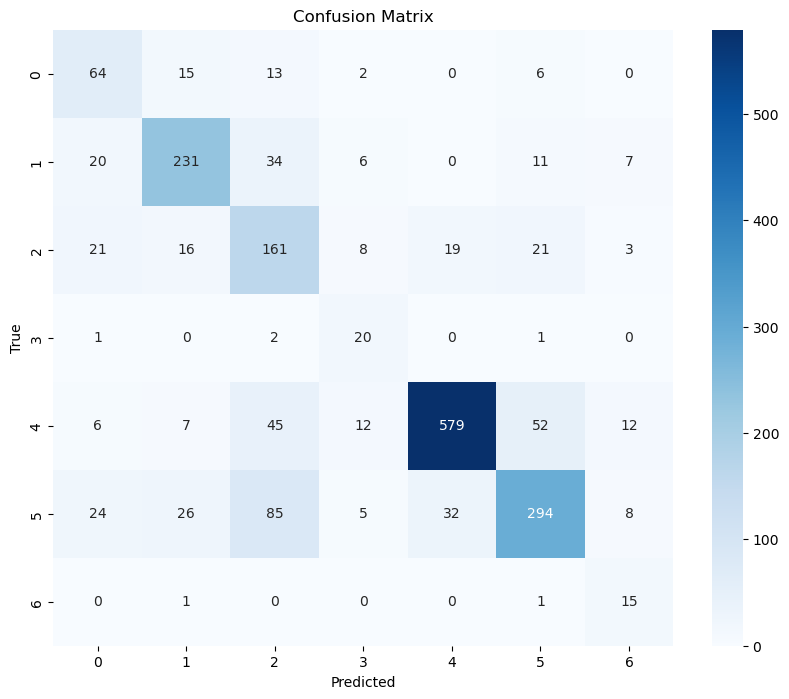

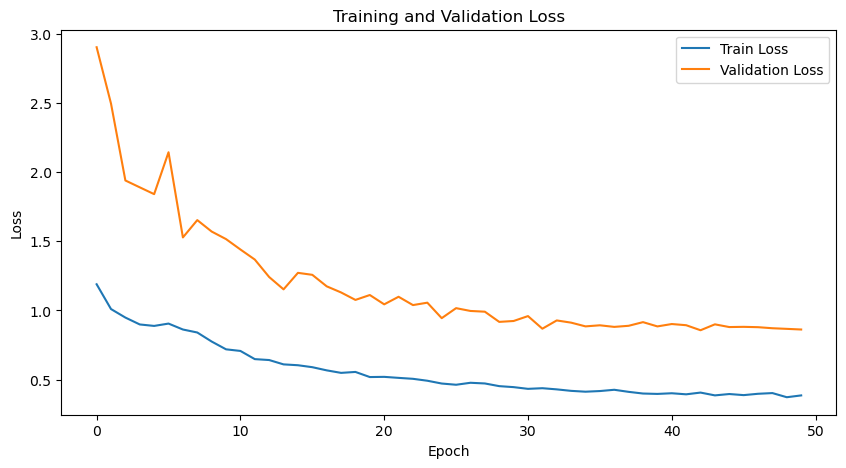

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training tracking
best_val_acc = 0
best_model_state = None
patience = 10
patience_counter = 0
train_losses = []
val_losses = []
val_predictions = []
val_targets = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        
        # Mixup augmentation
        images, labels_a, labels_b, lam = mixup_data(images, labels)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (lam * (predicted == labels_a).sum().item()
                   + (1 - lam) * (predicted == labels_b).sum().item())
        
        train_loop.set_postfix({
            'Loss': f'{running_loss/total:.4f}',
            'Acc': f'{correct/total:.4f}',
            'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_true = []
    
    val_loop = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
            
            val_loop.set_postfix({
                'Val Loss': f'{val_loss/val_total:.4f}',
                'Val Acc': f'{val_correct/val_total:.4f}'
            })
    
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    
    # Save predictions for confusion matrix
    val_predictions = val_preds
    val_targets = val_true
    
    print(f"\nEpoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'skin_cnn_best.pth')
        patience_counter = 0
    else:
        patience_counter += 1'
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            break

# Load best model and plot final confusion matrix
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with validation accuracy: {best_val_acc:.4f}")
    
    # Plot final confusion matrix
    plot_confusion_matrix(val_targets, val_predictions, range(num_classes))
    
# Plot loss curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Save the full model
torch.save(model, "skin_cnn_full_model.pth")

# Save a checkpoint with all necessary information
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'class_names': full_dataset.classes,
    'input_size': (128, 128),  # The image size we used for training
    'normalize_mean': [0.485, 0.456, 0.406],  # ImageNet stats we used
    'normalize_std': [0.229, 0.224, 0.225]
}
torch.save(checkpoint, "skin_cnn_checkpoint.pth")

print("Models saved successfully:")
print("1. Full model saved to 'skin_cnn_full_model.pth'")
print("2. Checkpoint saved to 'skin_cnn_checkpoint.pth'")
print("\nYou can use either file for inference:")
print("- Use 'skin_cnn_full_model.pth' for simple loading of the entire model")
print("- Use 'skin_cnn_checkpoint.pth' for more flexibility and access to model parameters")

Models saved successfully:
1. Full model saved to 'skin_cnn_full_model.pth'
2. Checkpoint saved to 'skin_cnn_checkpoint.pth'

You can use either file for inference:
- Use 'skin_cnn_full_model.pth' for simple loading of the entire model
- Use 'skin_cnn_checkpoint.pth' for more flexibility and access to model parameters


In [1]:
print(class_names)

NameError: name 'class_names' is not defined

In [2]:
print(dataset.class_to_idx)
print(class_names)


NameError: name 'dataset' is not defined

In [11]:
import pickle

# Get class names from the dataset
class_names = full_dataset.classes  # ['Actinic keratoses', 'Basal cell carcinoma', ...]

# Save class names to a pickle file
with open("class_names.pkl", "wb") as f:
    pickle.dump(class_names, f)

print("Saved class names:", class_names)
print("\nClass names have been saved to 'class_names.pkl'")

Saved class names: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']

Class names have been saved to 'class_names.pkl'
